# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [4]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
customers["Channel"].unique()

array([2, 1])

In [6]:
customers["Region"].unique()

array([3, 1, 2])

In [7]:
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [8]:
customers.corr()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [9]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


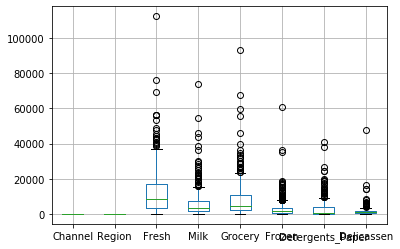

In [10]:
customers.boxplot()

In [11]:
customers["Sum"] = customers.apply(np.sum, axis=1)
top20 = customers.sort_values(by="Sum", ascending=False).head(customers.shape[0]//5)
print("Top 20% customers account for", round(top20["Sum"].sum() * 100 / customers["Sum"].sum(), 2), "%")

Top 20% customers account for 42.9 %


In [12]:
customers.drop("Sum", axis=1, inplace=True)

In [13]:
# Your observations here

# Each record represents data about one customer
# Channel is the place where purchases were made 1=Hotel+ restaurants+café and 2=retail
# Region is the geographical region of the stores 1=Lisbon, 2=Porto and 3=Other
# The other columns contain each customer's annual spending on each of these product categories

# There are no categorical variables and no missing data
# but Channel and Region represent a different type of information than the other columns

# There are some strong correlations between columns:
# (Grocery, Milk) and (Detergents_Paper, Grocery)

# On each product category, there are a lot of outliers with high expenditure values

# Pareto principle does not apply to this dataset.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [14]:
# Your code here
stats = customers.describe()
customers_wo_outliers = customers.copy()
for c in customers.columns[2:]:  # it doesn't make sense to look for outliers in Channel and Region
    iqr = stats[c]["75%"] - stats[c]["25%"]
    low_cutoff = stats[c]["25%"] - 2.9 * iqr
    upp_cutoff = stats[c]["75%"] + 2.9 * iqr
    customers_wo_outliers = customers_wo_outliers[(customers_wo_outliers[c]>low_cutoff) & (customers_wo_outliers[c]<upp_cutoff)]

In [15]:
(customers.shape[0] - customers_wo_outliers.shape[0]) * 100 / customers.shape[0]

8.863636363636363

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [16]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scalar = StandardScaler()
customers_scale = scalar.fit_transform(customers_wo_outliers)

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [17]:
# Your code here:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=67, n_jobs=-1)
clustered_kmean = model.fit(customers_scale)

customers_wo_outliers["labels"] = clustered_kmean.labels_

Count the values in `labels`.

In [18]:
# Your code here:
customers_wo_outliers["labels"].value_counts()

2    199
1    118
0     84
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data will have two labels, one from K-Means and the other from DBSCAN.

In [19]:
# Your code here
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.5)
clustered_dbscan = model.fit(customers_scale)

customers_wo_outliers["labels_DBSCAN"] = clustered_dbscan.labels_

Count the values in `labels_DBSCAN`.

In [20]:
# Your code here
customers_wo_outliers["labels_DBSCAN"].value_counts()

-1    337
 0     59
 1      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

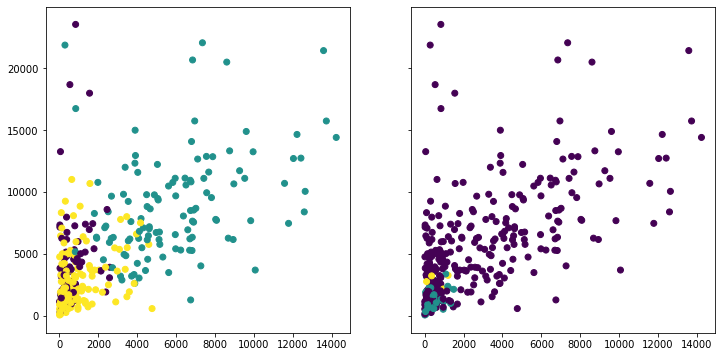

In [21]:
# Your code here:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

axs[0].scatter(customers_wo_outliers["Detergents_Paper"], customers_wo_outliers["Milk"], c=customers_wo_outliers["labels"], label=str(c))
axs[1].scatter(customers_wo_outliers["Detergents_Paper"], customers_wo_outliers["Milk"], c=customers_wo_outliers["labels_DBSCAN"], label="DBSCAN")


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

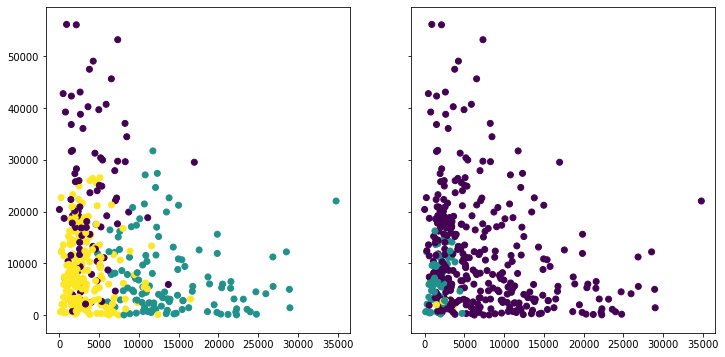

In [22]:
# Your code here:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

axs[0].scatter(customers_wo_outliers["Grocery"], customers_wo_outliers["Fresh"], c=customers_wo_outliers["labels"], label="K-Means")
axs[1].scatter(customers_wo_outliers["Grocery"], customers_wo_outliers["Fresh"], c=customers_wo_outliers["labels_DBSCAN"], label="DBSCAN")


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

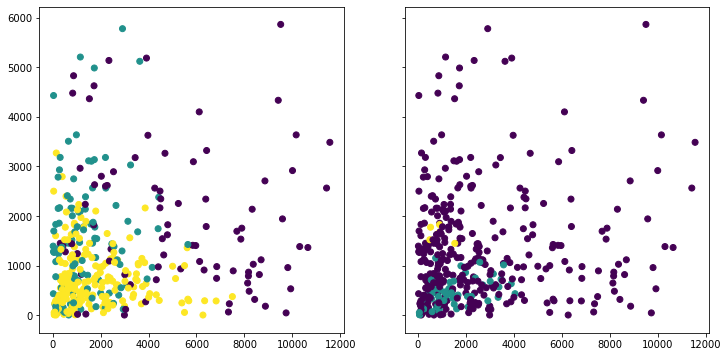

In [23]:
# Your code here:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

axs[0].scatter(customers_wo_outliers["Frozen"], customers_wo_outliers["Delicassen"], c=customers_wo_outliers["labels"], label="K-Means")
axs[1].scatter(customers_wo_outliers["Frozen"], customers_wo_outliers["Delicassen"], c=customers_wo_outliers["labels_DBSCAN"], label="DBSCAN")


Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [24]:
# Your code here:
customers_wo_outliers.groupby("labels").agg("mean").describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,1.349719,2.567212,12723.429043,5157.062453,7117.171746,2800.169647,2447.464112,1363.253040,-0.884422
std,0.527089,0.102818,8380.608809,3349.567718,5976.019444,2238.817417,3029.749389,582.991641,0.200187
min,1.020101,2.457286,7466.508475,2418.497487,3259.130653,1325.788136,655.583333,740.673367,-1.000000
25%,1.045765,2.520310,7891.095946,3289.754696,3675.291517,1512.069947,698.412270,1096.730751,-1.000000
50%,1.071429,2.583333,8315.683417,4161.011905,4091.452381,1698.351759,741.241206,1452.788136,-1.000000
75%,1.514528,2.622175,15351.889328,6526.344935,9046.192292,3537.360403,3343.404501,1674.542877,-0.826633
max,1.957627,2.661017,22388.095238,8891.677966,14000.932203,5376.369048,5945.567797,1896.297619,-0.653266


In [25]:
# Your observations here
customers_wo_outliers.groupby("labels_DBSCAN").agg("mean").describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,1.121662,2.818991,6933.620456,3164.545753,3911.459991,1616.908823,1186.947774,1134.124897,1.717112
std,0.210724,0.313517,4909.061800,2054.510758,3116.356384,850.493319,1234.797015,622.978652,0.489977
min,1.000000,2.456973,2053.200000,1228.508475,1816.644068,869.800000,378.000000,440.101695,1.151335
25%,1.000000,2.728487,4465.015254,2086.854237,2120.822034,1154.128814,476.300000,878.687346,1.575668
50%,1.000000,3.000000,6876.830508,2945.200000,2425.000000,1438.457627,574.600000,1317.272997,2.000000
75%,1.182493,3.000000,9373.830685,4132.564392,4958.867953,1990.463235,1591.421662,1481.136499,2.000000
max,1.364985,3.000000,11870.830861,5319.928783,7492.735905,2542.468843,2608.243323,1645.000000,2.000000


Which algorithm appears to perform better?

In [26]:
# Your observations here
# The standard deviations on all categories except Delicassen
# are lower in the DBSCAN model than in the K-means model. This
# means that the clusters are "packed more tightly" in the DBSCAN results.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [110]:
# Your code here

k=8

model = KMeans(n_clusters=k, random_state=67, n_jobs=-1)
clustered_kmean = model.fit(customers_scale)
customers_wo_outliers["labels"] = clustered_kmean.labels_
stats = customers_wo_outliers.groupby("labels").agg("mean").describe()
print(stats[stats.index=="std"])

      Channel   Region         Fresh         Milk      Grocery      Frozen  \
std  0.427104  0.57883  10412.751858  5475.210749  6388.215462  2136.43492   

     Detergents_Paper   Delicassen  labels_DBSCAN  
std       3001.402801  1317.630242       0.195161  


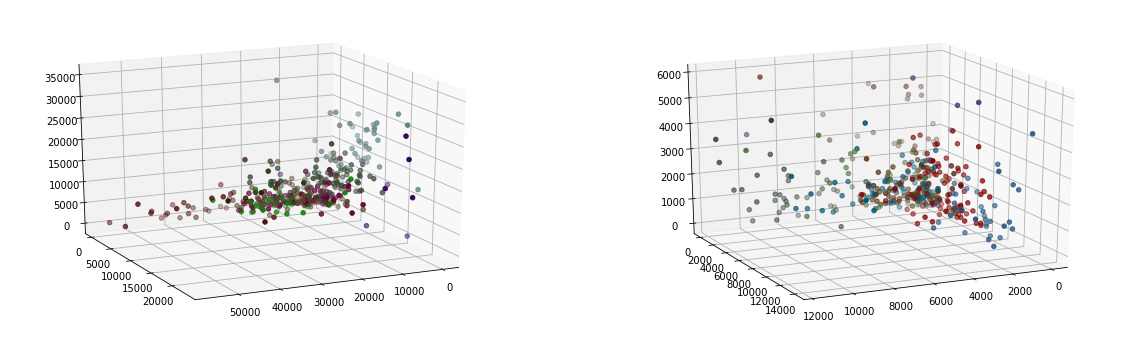

In [112]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
for h,c in [(''.join(["#"] + list(np.random.randint(0, 9, 6).astype(str))), i) for i in range(k)]:#('r', 0), ('g', 1), ('b', 2), ('y', 3)]:
    g = customers_wo_outliers[customers_wo_outliers["labels"]==c]
    ax.scatter(g["Fresh"], g["Milk"], g["Grocery"], color=h)
    ax.view_init(elev=20, azim=65)

ax = fig.add_subplot(1, 2, 2, projection='3d')
for h,c in [(''.join(["#"] + list(np.random.randint(0, 9, 6).astype(str))), i) for i in range(k)]:
    g = customers_wo_outliers[customers_wo_outliers["labels"]==c]
    ax.scatter(g["Frozen"], g["Detergents_Paper"], g["Delicassen"], color=h)
    ax.view_init(elev=20, azim=65)

plt.show()


In [ ]:
# Your comment here
# It's hard to tell by looking at the graphs.
# Looking at the standard deviations of the clusters, k=2 seems to produce best results overall
# but I'd have to check more carefully.

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here